# YouTube Dislikes predictions

This notebook contains code to:
- transform initial dataset using TextVectorization
- create pretrained Embedding layers
- train a neural network to predict the number of dislikes

## Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.utils import plot_model

## Helper functions

In [3]:
def create_vectorizer(text, max_tokens=10000, sentence_length=1000):
    """ 
    Create TextVectorization() layer based on text

    Parameters:
        text (array of strings): text
        max_tokens (int): layer will consider the top 'max_tokens' words.
            Size of the vocabulary
        sentence_length (int): maximum number of words in a sentence.
            Longer sentences will be truncate, shorter ones will be pad

    Returns:
        vectorizer layer (tf.keras.layers.TextVectorization)
    """

    # create a vectorizer object
    vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                          output_sequence_length=sentence_length)
    vectorizer.adapt(text)

    return vectorizer

In [4]:
def create_embedding_matrix(vocabulary,
                            path_to_emb_file='embeddings/glove.6B/glove.6B.50d.txt',
                            emb_dim=50):
    """ 
    Create an embedding matrix based on pretrained GloVe embeddings
    and a vocabulary obtained by TextVectorization layer

    Parameters:
        path_to_emb_file (str): path to word embeddings .txt file
        vocabulary (list): vocabulary obtained by TextVectorization with get_vocabulary().
            List of top 'max_tokens' words from text
        emb_dim (int): embedding dimentions

    Returns:
        embedding_matrix with shape=(num_tokens, emb_dim) 
        where num_tokens = len(vocabulary) + 2 (two extra tokens - pad and OOV)
    """

    # Read embedding text file
    try:
        f = open(path_to_emb_file, encoding="utf8")
    except OSError:
        print(f"Could not open/read file: {path_to_emb_file}.")
        return None

    embeddings_index = {}
    with f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")

    # +2 for padding and OOV (out of vocabulary) tokens
    num_tokens = len(vocabulary) + 2
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    embedding_dim = emb_dim
    hits = 0
    misses = 0

    # Create and fill embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            misses += 1
    print(f"Converted {hits} words ({misses} misses)")

    return embedding_matrix

In [5]:
def init_embedding_layer(emb_matrix, name=''):
    """ 
    Create a non-trainable Embedding layer initialized with emb_matrix 

    Parameters:
        emb_matrix (matrix of shape (num_tokens, embedding_dim)): embedding matrix
        name (str): name of the layer

    Returns:
        embedding layer (tf.keras.layers.Embedding)
    """

    num_tokens, embedding_dim = emb_matrix.shape

    embedding_layer = layers.Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(emb_matrix),
        trainable=False,
        name=name
    )

    return embedding_layer

In [6]:
def pretrained_embedding_layer(vocabulary, name='',
                               path_to_emb_file='embeddings/glove.6B/glove.6B.50d.txt',
                               emb_dim=50):
    """ 
    Combine create_embedding_matrix() and init_embedding_layer() functions
    to create non-trainable Embedding layer based on vocabulary and 
    word embeddings

    Parameters:
        vocabulary (list): vocabulary obtained by TextVectorization with get_vocabulary().
            List of top 'max_tokens' words from text
        name (str): name of the layer
        path_to_emb_file (str): path to word embeddings .txt file
        emb_dim (int): embedding dimentions. 
            In case of GloVe can be 50, 100, 200 or 300

    Returns:
        embedding layer (tf.keras.layers.Embedding)
    """

    embedding_matrix = create_embedding_matrix(
        vocabulary=vocabulary,
        path_to_emb_file=path_to_emb_file,
        emb_dim=emb_dim)

    embedding_layer = init_embedding_layer(embedding_matrix, name=name)

    return embedding_layer

# Dataset Transformations

## Read and split dataset 

In [7]:
df = pd.read_csv(
    'datasets/youtube_custom_dataset/data/youtube_dislike_dataset.csv')
df

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments
0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi..."
1,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...
2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...
3,--4tfbSyYDE,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO,UCsmXiDP8S40uBeJYxvyulmA,JO1,2021-03-03 10:00:17,2641597,39131,441,3745,PRODUCE101JAPAN JO1 TheSTAR STA...,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO\n\n---...,youngVer>< REN is really PERFECT. It's not ju...
4,--DKkzWVh-E,Why Retaining Walls Collapse,UCMOqf8ab-42UUQIdVoKwjlQ,Practical Engineering,2021-12-07 13:00:00,715724,32887,367,1067,retaining wall New Jersey highway Direct Conne...,One of the most important (and innocuous) part...,Keep up with all my projects here: https://pr...
...,...,...,...,...,...,...,...,...,...,...,...,...
37417,zzd4ydafGR0,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,UCEB4a5o_6KfjxHwNMnmj54Q,Lil Tjay,2021-02-12 05:03:49,120408275,2180780,35871,81360,Lil Tjay Steady Calling My Phone Calling My Ph...,"Official video for ""Calling My Phone"" by Lil T...",'DESTINED 2 WIN' OUT NOW !! https://liltjay.ln...
37418,zziBybeSAtw,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,2021-01-16 05:39:05,2841917,20759,1049,2624,NBA G League Basketball game-0022000187 Lakers...,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,Montrezl Harrell is going crazy with the rebou...
37419,zzk09ESX7e0,[MV] (MAMAMOO) - Where Are We Now,UCuhAUMLzJxlP1W7mEk0_6lA,MAMAMOO,2021-06-02 09:00:10,13346678,720854,4426,90616,MAMAMOO WAW WAW MAMAMOO WAW Where Are We Now...,[MV] (MAMAMOO) - Where Are We Now\n\nInstagra...,I honestly do not know why this song hit so ha...
37420,zzmQEb0Em5I,FELLIPE ESCUDERO- Master Podcast #12,UC8NjnNWMsRqq11NYvHAQb1g,Master Podcast,2020-10-20 20:59:30,252057,19198,1234,1471,master masterpodcast lord lord vinheteiro z z ...,DOCTOR HAIR\nhttps://www.thedoctorhair.com/?fb...,Foi um prazer passar esta tarde com vocs debat...


In [8]:
df.dropna(inplace=True)

In [9]:
# create one column that contains all author text
df['author_text'] = df[['title', 'channel_title',
                        'tags', 'description']].agg(' '.join, axis=1)

## Final version of the dataset

In [10]:
# dataset we will use
X = df[['view_count', 'likes', 'comment_count', 'author_text', 'comments']]
y = df['dislikes'].to_numpy()

In [11]:
print(X.shape)
X

(37264, 5)


,view_count,likes,comment_count,author_text,comments
0,1048888,19515,1319,Jadon Sancho Magical Skills & Goals Bundeslig...,"Respect to Dortmund fans,must be sad losing hi..."
1,15352638,359277,18729,Migos - Avalanche (Official Video) MigosVEVO M...,Migos just makes me want to live my live to th...
2,925281,11212,831,Supporting Actress in a Comedy: 73rd Emmys Tel...,Hannah's energy bursts through any screen. Wel...
3,2641597,39131,3745,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO JO1 PR...,youngVer>< REN is really PERFECT. It's not ju...
4,715724,32887,1067,Why Retaining Walls Collapse Practical Enginee...,Keep up with all my projects here: https://pr...
...,...,...,...,...,...
37417,120408275,2180780,81360,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,'DESTINED 2 WIN' OUT NOW !! https://liltjay.ln...
37418,2841917,20759,2624,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,Montrezl Harrell is going crazy with the rebou...
37419,13346678,720854,90616,[MV] (MAMAMOO) - Where Are We Now MAMAMOO MAM...,I honestly do not know why this song hit so ha...
37420,252057,19198,1471,FELLIPE ESCUDERO- Master Podcast #12 Master P...,Foi um prazer passar esta tarde com vocs debat...


In [12]:
print(y.shape)
y

(37264,)


array([ 226, 7479,  401, ..., 4426, 1234,  868], dtype=int64)

## Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=42)

## Preprocessing numeric data

All we need to do - convert pd.Series to numpy array

In [14]:
numeric_data = X_train[['view_count', 'likes', 'comment_count']].to_numpy()
print(numeric_data.shape)
numeric_data

(36264, 3)


array([[  784141,    38832,     3120],
       [  981298,    13873,     1797],
       [  298217,    14361,      612],
       ...,
       [15785099,   447133,   104008],
       [ 1479158,   135339,     6882],
       [  133894,     5063,      659]], dtype=int64)

## Preprocessing text data

1. Read text data from pd.Series to numpy array
2. Create a vectorizer object that will convert text to vectors of fixed length
3. Get vocabulary from the vectorizer. Vocabulary is a list of words, that appear in the text. It will be used to create an Embedding layer
4. Transform text to vectors

This needs to be done for `author_text` and `comments`, but with different objects

In [15]:
max_tokens = 20000
sentence_length = 2000

### author_text_data

In [16]:
author_text = X_train['author_text'].to_numpy()
author_text.shape

(36264,)

In [17]:
vectorizer_author = create_vectorizer(
    author_text, max_tokens, sentence_length)

In [18]:
vocabulary_author = vectorizer_author.get_vocabulary()

In [19]:
author_text_data = vectorizer_author(author_text)
author_text_data.shape

TensorShape([36264, 2000])

### comments_data

In [20]:
comments = X_train['comments'].to_numpy().astype('object')
comments.shape

(36264,)

In [21]:
vectorizer_comments = create_vectorizer(
    comments, max_tokens, sentence_length)

In [22]:
vocabulary_comments = vectorizer_comments.get_vocabulary()

In [23]:
comments_data = vectorizer_comments(comments)
comments_data.shape

TensorShape([36264, 2000])

# Model

## Create pre-trained Endebbings layers

In [24]:
embeddings_1 = pretrained_embedding_layer(vocabulary_author,
                                          name='pretrained_embeddings_for_author_text')

Found 400000 word vectors.
Converted 15720 words (4280 misses)


In [25]:
embeddings_2 = pretrained_embedding_layer(vocabulary_comments,
                                          name='pretrained_embeddings_for_comments')

Found 400000 word vectors.
Converted 17222 words (2778 misses)


## Model architecture

In [55]:
def fully_connected(verbose=False):
    
    # 3 vectors of numbers
    numbers_input = keras.Input(shape=(3,), name="numbers_input")

    # Final part of the model
    dense_1 = layers.Dense(32, activation='relu', name='dense_32_units_1')(numbers_input)
    dropout_1 = layers.Dropout(0.1, name="dropout_1")(dense_1)
    dense_2 = layers.Dense(32, activation='relu', name='dense_32_units_2')(dropout_1)
    dropout_2 = layers.Dropout(0.1, name="dropout_2")(dense_2)
    dense_3 = layers.Dense(16, activation='relu', name='dense_16_units')(dropout_2)
    dropout_3 = layers.Dropout(0.1, name="dropout_3")(dense_3)
    output = layers.Dense(1, activation='relu', name='output')(dropout_3)


    model = keras.Model(inputs=numbers_input,
                        outputs=output,
                        name="dislikes_predictor")
    if verbose:
        # summarize layers
        print(model.summary())
        # plot model architecture
        plot_model(model, show_shapes=True)
                   # to_file='article/img/network_architecture.png')
            
    return model

In [56]:
model = fully_connected(verbose=True)

Model: "dislikes_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numbers_input (InputLayer)  [(None, 3)]               0         
                                                                 
 dense_32_units_1 (Dense)    (None, 32)                128       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_32_units_2 (Dense)    (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_16_units (Dense)      (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)         

In [57]:
model_name_to_save = 'fully_connected'

In [58]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=['accuracy']
)

In [59]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = keras.callbacks.ModelCheckpoint(
    f"models/{model_name_to_save}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1)

callbacks = [checkpoint]

history = model.fit(numeric_data,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                   callbacks=callbacks)

model.save(f"models/{model_name_to_save}.h5")

Epoch 1/10
390/454 [========================>.....] - ETA: 0s - loss: 5163.0405 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 4877.88574, saving model to models\fully_connected.h5
454/454 [==============================] - 1s 1ms/step - loss: 5058.4443 - accuracy: 0.0000e+00 - val_loss: 4877.8857 - val_accuracy: 0.0000e+00
Epoch 2/10
452/454 [============================>.] - ETA: 0s - loss: 5057.7158 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 4877.88574
454/454 [==============================] - 0s 927us/step - loss: 5054.2681 - accuracy: 0.0000e+00 - val_loss: 4877.8857 - val_accuracy: 0.0000e+00
Epoch 3/10
398/454 [=========================>....] - ETA: 0s - loss: 5117.3418 - accuracy: 0.0000e+00
Epoch 00003: val_loss did not improve from 4877.88574
454/454 [==============================] - 0s 905us/step - loss: 5054.2676 - accuracy: 0.0000e+00 - val_loss: 4877.8857 - val_accuracy: 0.0000e+00
Epoch 4/10
392/454 [========================>..

Model: "dislikes_predictor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 author_text_input (InputLayer)  [(None, None)]      0           []                               
                                                                                                  
 comments_input (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 pretrained_embeddings_for_auth  (None, None, 50)    1000100     ['author_text_input[0][0]']      
 or_text (Embedding)                                                                              
                                                                                                  
 pretrained_embeddings_for_comm  (None, None, 50)    1000100     ['comments_input

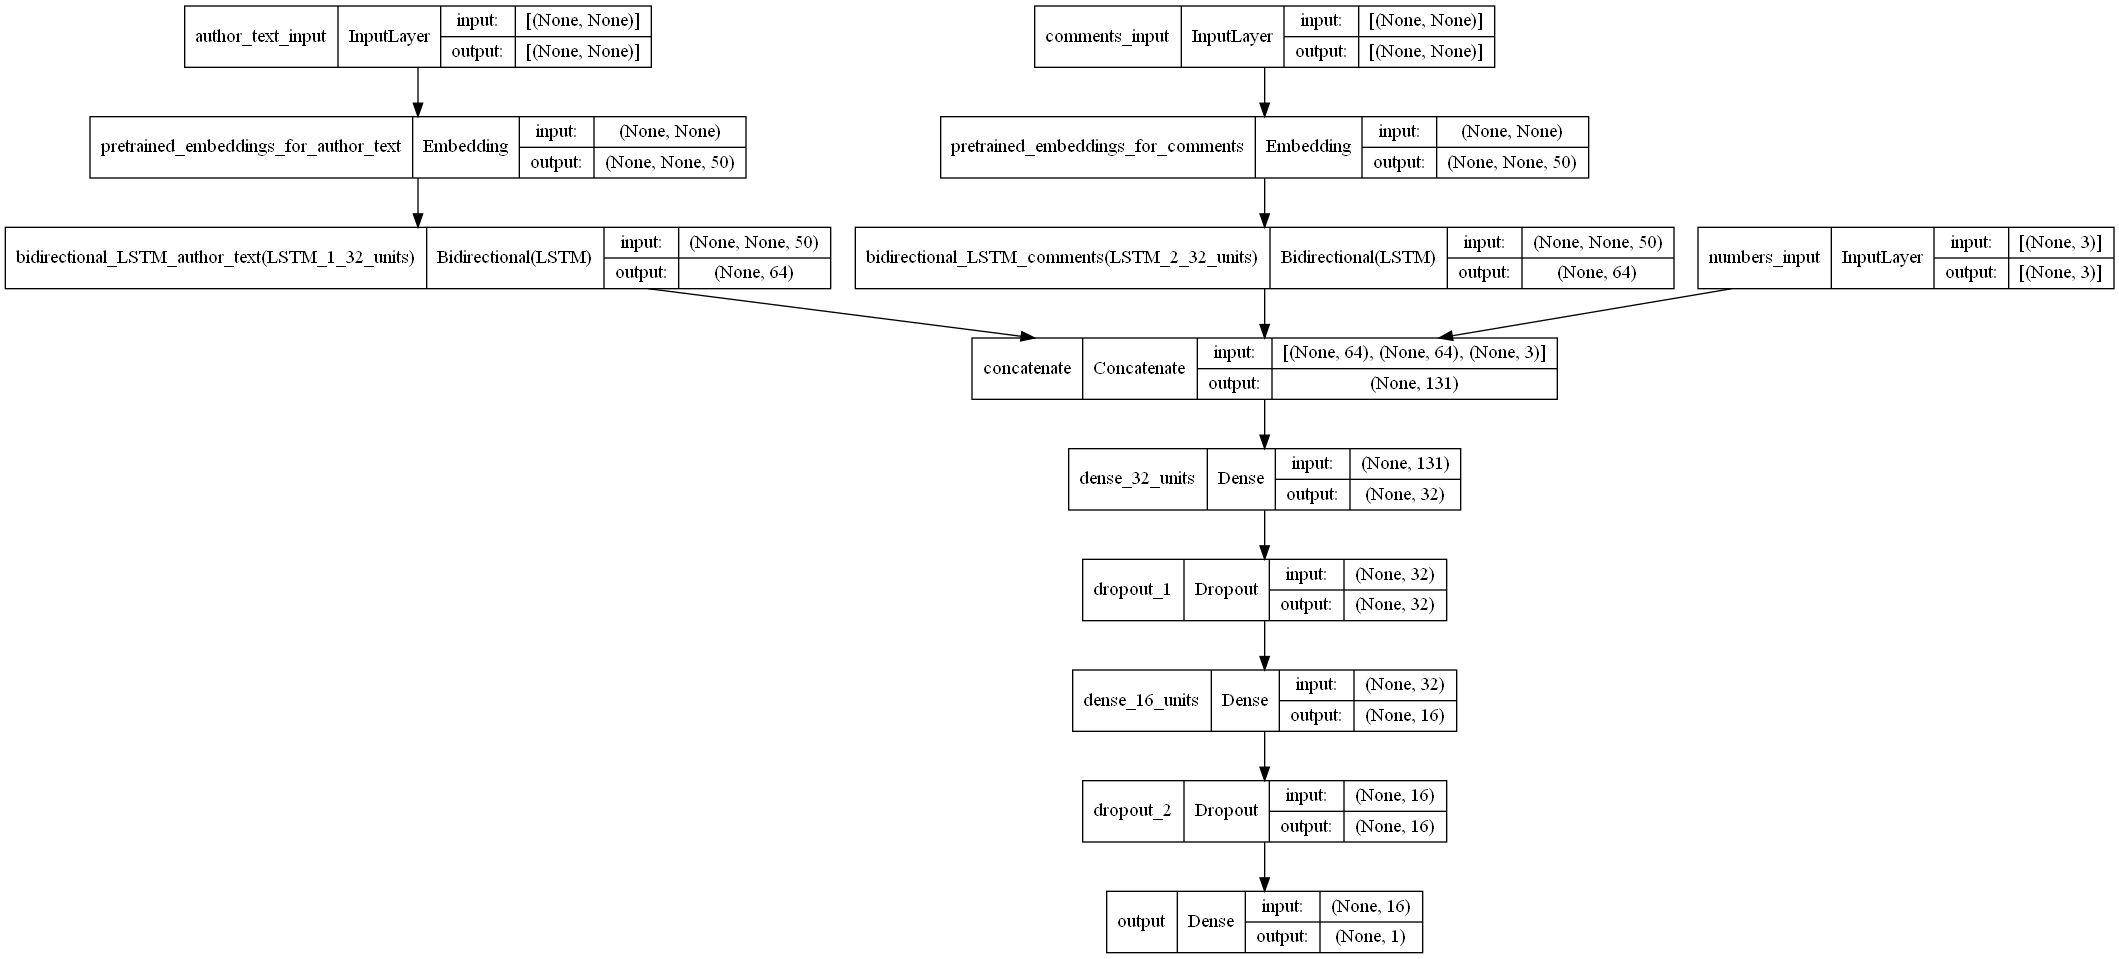

In [26]:
# Variable-length sequence of ints
text_1_input = keras.Input(shape=(None,), name="author_text_input")

# Variable-length sequence of ints
text_2_input = keras.Input(shape=(None,), name="comments_input")

# 3 vectors of numbers
numbers_input = keras.Input(shape=(3,), name="numbers_input")

# Embed each word into a 50-dimensional vector using pretrained GloVe embeddings
text_1_features = embeddings_1(text_1_input)
text_2_features = embeddings_2(text_2_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
# uncomment for 2-layers LSTM

# text_1_features = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(text_1_features)
text_1_features = layers.Bidirectional(layers.LSTM(
    32, name="LSTM_1_32_units"), name="bidirectional_LSTM_author_text")(text_1_features)
# text_2_features = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(text_2_features)
text_2_features = layers.Bidirectional(layers.LSTM(
    32, name="LSTM_2_32_units"), name="bidirectional_LSTM_comments")(text_2_features)

# Merge all available features into a single large vector via concatenation
concat = layers.concatenate(
    [text_1_features, text_2_features, numbers_input], name='concatenate')

# Final part of the model
dense_1 = layers.Dense(32, activation='relu', name='dense_32_units')(concat)
dropout_1 = layers.Dropout(0.3, name="dropout_1")(dense_1)
dense_2 = layers.Dense(16, activation='relu', name='dense_16_units')(dropout_1)
dropout_2 = layers.Dropout(0.3, name="dropout_2")(dense_2)
output = layers.Dense(1, activation='relu', name='output')(dropout_2)


model = keras.Model(inputs=[text_1_input, text_2_input, numbers_input],
                    outputs=output,
                    name="dislikes_predictor")

# summarize layers
print(model.summary())
# plot model architecture
plot_model(model, show_shapes=True,
           to_file='article/img/network_architecture.png')

## Compile and train a model

In [27]:
# X_train in a form understandable to the network
train_data = {"author_text_input": author_text_data,
              "comments_input": author_text_data,
              "numbers_input": numeric_data}

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['accuracy']
)

In [29]:
model_name_to_save = 'model_5_epoch'

In [30]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = keras.callbacks.ModelCheckpoint(
    f"models/{model_name_to_save}.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1)

callbacks = [checkpoint]

In [38]:
history = model.fit(train_data,
                    y_train,
                    epochs=5,
                    batch_size=32,
                    callbacks=callbacks,
                    validation_split=0.2)

model.save(f"models/{model_name_to_save}.h5")

Epoch 1/5
 29/907 [..............................] - ETA: 10:03 - loss: 747109760.0000 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [32]:
import pickle

pickle.dump(history, open('models/history.p', "wb"))

INFO:tensorflow:Assets written to: ram://26382e09-1366-4a30-90e2-168d0ee1e09f/assets


INFO:tensorflow:Assets written to: ram://26382e09-1366-4a30-90e2-168d0ee1e09f/assets


NotFoundError: 

In [34]:
import matplotlib.pyplot as plt

KeyError: 'val_accuracy'

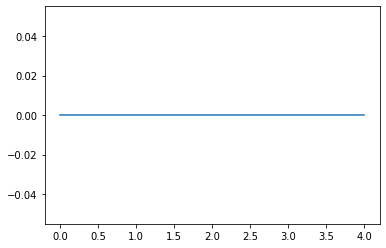

In [36]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'val_loss'

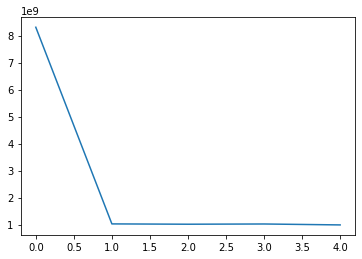

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()